# Naturalistic textural filters for MR images.

In this notebook I implement various transforms which model artifacts that commonly occur in MRI. Here I focus on the types of corruptions which may occur during data acquisition so I work in k-space.

I have contributed versions of the transforms presented here to the open source medial AI library [MONAI](https://monai.io/).  

The MR images I use are part of the BraTS Challenge dataset and it comes from http://medicaldecathlon.com/.

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from monai.apps import DecathlonDataset
from monai.utils import ensure_tuple
from monai.transforms import (
    Transform,
    RandomizableTransform,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)

import torch
from tqdm import tqdm
from typing import Optional, Union, Sequence, Tuple, Any

#################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)
from utils import show_slice_and_fourier


root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'

## Get data

In [2]:
transforms = Compose(
    [
        LoadImaged("image"),
        AsChannelFirstd("image"),
        Spacingd(
            "image",
            pixdim=(1.5, 1.5, 2.0),
            mode="bilinear",
        ),
        Orientationd("image", axcodes="RAS"),
        CenterSpatialCropd("image", roi_size=[128, 128, 64]),
        NormalizeIntensityd("image", nonzero=True, channel_wise=True),
        ToTensord("image")
    ]
)

ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=10
)

Loading dataset: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


## Check data shape and visualize

image shape: torch.Size([4, 128, 128, 64])


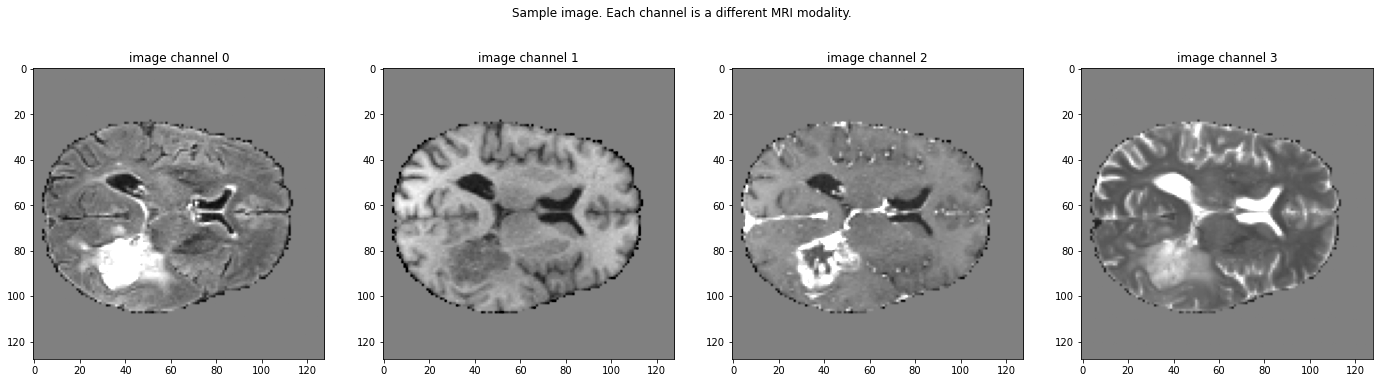

In [3]:
print(f"image shape: {ds[20]['image'].shape}")

# pick one image from DecathlonDataset to visualize and check the 4 channels
img = ds[20]['image']

plt.figure(figsize=(24,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(f'image channel {i}')
    plt.imshow(img[i, :, :, 32], cmap="gray", vmin=-2.5, vmax=2.5)
    plt.suptitle('Sample image. Each channel is a different MRI modality.')
plt.show()

# Helper Fourier transform class

In [ ]:
class FourierTransform:
    """This class stores fourier mappings we use in various artifact transforms"""
    
    @staticmethod
    def shift_fourier(x: torch.Tensor, n_dims: int) -> torch.tensor:
        """
        Applies fourier transform and shifts its output.
        Only the spatial dimensions get transformed.

        Args:
            x (torch.tensor): tensor to fourier transform.
        """
        out: torch.tensor = torch.fft.fftshift(torch.fft.fftn(x, dim=tuple(range(-n_dims, 0))), 
                                               dim=tuple(range(-n_dims, 0)))
        return out
    
    @staticmethod
    def inv_shift_fourier(k: torch.Tensor, n_dims: int) -> torch.tensor:
        """
        Applies inverse shift and fourier transform. Only the spatial
        dimensions are transformed.
        """
        out: torch.tensor = torch.fft.ifftn(
            torch.fft.ifftshift(k, dim=tuple(range(-n_dims, 0))), dim=tuple(range(-n_dims, 0))
        ).real
        return out

# Gibbs artifact

For general information on Gibbs artifacts, please refer to the publications:

[An Image-based Approach to Understanding the Physics of MR Artifacts.](https://pubs.rsna.org/doi/full/10.1148/rg.313105115)

[The AAPM/RSNA Physics Tutorial for Residents.](https://pubs.rsna.org/doi/full/10.1148/radiographics.22.4.g02jl14949)

![title](figures/gibbs_example.png)

In [61]:
class GibbsNoise(Transform, FourierTransform):
    """
    The transform applies Gibbs noise to 2D/3D MRI images. Gibbs artifacts
    are one of the common type of type artifacts appearing in MRI scans.

    The transform is applied to all the channels in the data.

    Args:
        alpha (float): Parametrizes the intensity of the Gibbs noise filter applied. Takes
            values in the interval [0,1] with alpha = 0 acting as the identity mapping.
        as_tensor_output: if true return torch.Tensor, else return np.array. default: True.
    """

    def __init__(self, alpha: float = 0.5, as_tensor_output: bool = True) -> None:

        if alpha > 1 or alpha < 0:
            raise AssertionError("alpha must take values in the interval [0,1].")
        self.alpha = alpha
        self.as_tensor_output = as_tensor_output
        self._device = torch.device("cpu")

    def __call__(self, img: Union[np.ndarray, torch.Tensor]) -> Union[torch.Tensor, np.ndarray]:
        n_dims = len(img.shape[1:])

        # FT
        k = self.shift_fourier(img, n_dims)
        # build and apply mask
        k = self._apply_mask(k)
        # map back
        img = self.inv_shift_fourier(k, n_dims)
        return img

    def _apply_mask(self, k: np.ndarray) -> np.ndarray:
        """Builds and applies a mask on the spatial dimensions.

        Args:
            k (np.ndarray): k-space version of the image.
        Returns:
            masked version of the k-space image.
        """
        shape = k.shape[1:]

        # compute masking radius and center
        r = (1 - self.alpha) * np.max(shape) * np.sqrt(2) / 2.0
        center = (np.array(shape) - 1) / 2

        # gives list w/ len==self.dim. Each dim gives coordinate in that dimension
        coords = np.ogrid[tuple(slice(0, i) for i in shape)]

        # need to subtract center coord and then square for Euc distance
        coords_from_center_sq = [(coord - c) ** 2 for coord, c in zip(coords, center)]
        dist_from_center = np.sqrt(sum(coords_from_center_sq))
        mask = dist_from_center <= r

        # add channel dimension into mask
        mask = np.repeat(mask[None], k.shape[0], axis=0)

        # apply binary mask
        k_masked: np.ndarray = k * mask
        return k_masked

Example of ``GibbsNoise`` usage:

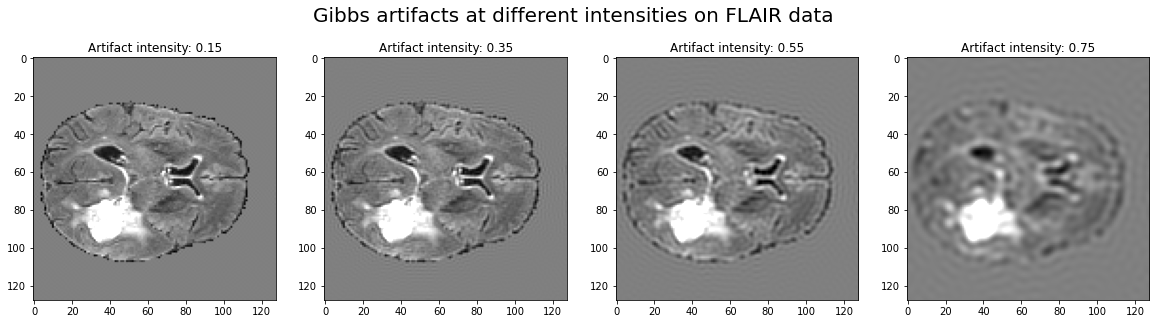

In [62]:
plt.figure(figsize=(20,5))
for i, alpha in enumerate([0.15, 0.35, .55, .75]):
    gibbs = GibbsNoise(alpha)
    out = gibbs(img)
    plt.subplot(1,4,i+1)
    plt.title(f'Artifact intensity: {alpha}')
    plt.imshow(out[0, :, :, 32], cmap="gray", vmin=-2.5, vmax=2.5)
    plt.suptitle('Gibbs artifacts at different intensities on FLAIR data', size=20)
plt.show()

#### Random version for naturalistic data augmentation

In [63]:
class RandGibbsNoise(RandomizableTransform, FourierTransform):
    """
    Naturalistic image augmentation via Gibbs artifacts. The transform
    randomly applies Gibbs noise to 2D/3D MRI images. Gibbs artifacts
    are one of the common type of type artifacts appearing in MRI scans.

    The transform is applied to all the channels in the data.


    Args:
        prob (float): probability of applying the transform.
        alpha (float, Sequence(float)): Parametrizes the intensity of the Gibbs noise filter applied. Takes
            values in the interval [0,1] with alpha = 0 acting as the identity mapping.
            If a length-2 list is given as [a,b] then the value of alpha will be
            sampled uniformly from the interval [a,b]. 0 <= a <= b <= 1.
        as_tensor_output: if true return torch.Tensor, else return np.array. default: True.
    """

    def __init__(self, prob: float = 0.1, alpha: Sequence[float] = (0.0, 1.0), as_tensor_output: bool = True) -> None:

        if len(alpha) != 2:
            raise AssertionError("alpha length must be 2.")
        if alpha[1] > 1 or alpha[0] < 0:
            raise AssertionError("alpha must take values in the interval [0,1]")
        if alpha[0] > alpha[1]:
            raise AssertionError("When alpha = [a,b] we need a < b.")

        self.alpha = alpha
        self.sampled_alpha = -1.0  # stores last alpha sampled by randomize()
        self.as_tensor_output = as_tensor_output

        RandomizableTransform.__init__(self, prob=prob)

    def __call__(self, img: Union[np.ndarray, torch.Tensor]) -> Union[torch.Tensor, np.ndarray]:

        # randomize application and possibly alpha
        self._randomize(None)

        if self._do_transform:
            # apply transform
            transform = GibbsNoise(self.sampled_alpha, self.as_tensor_output)
            img = transform(img)
        else:
            if isinstance(img, np.ndarray) and self.as_tensor_output:
                img = torch.Tensor(img)
            elif isinstance(img, torch.Tensor) and not self.as_tensor_output:
                img = img.detach().cpu().numpy()
        return img
    
    def _randomize(self, _: Any) -> None:
        """
        (1) Set random variable to apply the transform.
        (2) Get alpha from uniform distribution.
        """
        super().randomize(None)
        self.sampled_alpha = self.R.uniform(self.alpha[0], self.alpha[1])

Example of ``RandGibbsNoise`` usage:

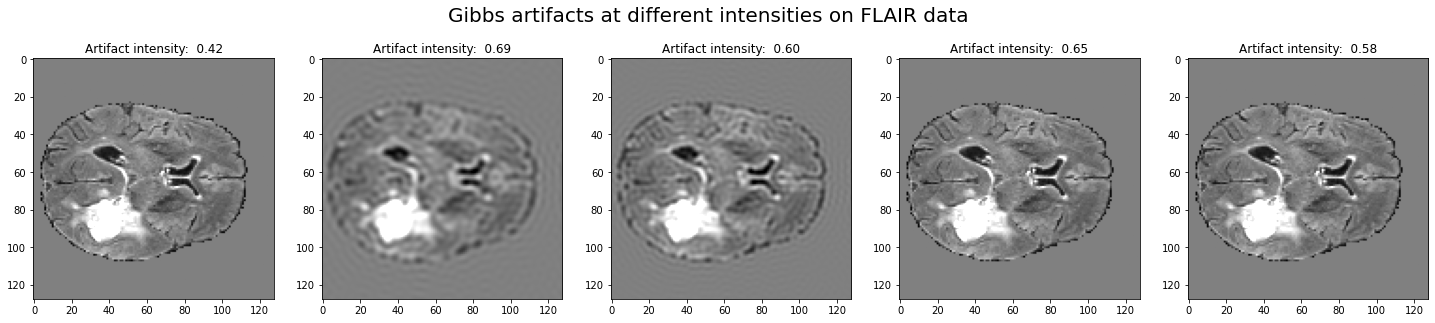

In [64]:
# prob = probability of being applied at all

gibbs = RandGibbsNoise(prob=.7, alpha=(.4,.7))

plt.figure(figsize=(25,5))
for i in range(5):
    out = gibbs(img)
    plt.subplot(1,5,i+1)
    plt.title(f'Artifact intensity: {gibbs.sampled_alpha : .2f}')
    plt.imshow(out[0, :, :, 32], cmap="gray", vmin=-2.5, vmax=2.5)
    plt.suptitle('Gibbs artifacts at different intensities on FLAIR data', size=20)
plt.show()

# Spike (Herringbone) artifact

Spikes artifacts is another type of image corruption that occurs naturally in MR images. They show up as various plane waves in the image and are acquired as corrupted pixels in the k-space data with anomalously high amplitudes.

For more information, please refer to the following publications:

[AAPM/RSNA physics tutorial for residents: fundamental physics of MR imaging](https://pubmed.ncbi.nlm.nih.gov/16009826)

[Body MRI artifacts in clinical practice: A physicist's and radiologist's perspective](https://doi.org/10.1002/jmri.24288)

![Spike artifact example](figures/spike_example.png)

In [69]:
class KSpaceSpikeNoise(Transform, FourierTransform):
    """
    Apply localized spikes in `k`-space at the given locations and intensities.
    Spike (Herringbone) artifact is a type of data acquisition artifact which
    may occur during MRI scans.

    Args:
        loc: spatial location for the spikes. For
            images with 3D spatial dimensions, the user can provide (C, X, Y, Z)
            to fix which channel C is affected, or (X, Y, Z) to place the same
            spike in all channels. For 2D cases, the user can provide (C, X, Y)
            or (X, Y).
        k_intensity: value for the log-intensity of the
            `k`-space version of the image. If one location is passed to ``loc`` or the
            channel is not specified, then this argument should receive a float. If
            ``loc`` is given a sequence of locations, then this argument should
            receive a sequence of intensities. This value should be tested as it is
            data-dependent. The default values are the 2.5 the mean of the
            log-intensity for each channel.
        as_tensor_output: if ``True`` return torch.Tensor, else return np.array.
            Default: ``True``.
    """
    
    def __init__(
        self,
        loc: Union[Tuple, Sequence[Tuple]],
        k_intensity: Optional[Union[Sequence[float], float]] = None,
        as_tensor_output: bool = True,
    ):

        self.loc = ensure_tuple(loc)
        self.as_tensor_output = as_tensor_output
        self.k_intensity = k_intensity

        # assert one-to-one relationship between factors and locations
        if isinstance(k_intensity, Sequence):
            if not isinstance(loc[0], Sequence):
                raise AssertionError(
                    "If a sequence is passed to k_intensity, then a sequence of locations must be passed to loc"
                )
            elif len(k_intensity) != len(loc):
                raise AssertionError("There must be one intensity_factor value for each tuple of indices in loc.")
        if isinstance(self.loc[0], Sequence) and k_intensity is not None:
            if not isinstance(self.k_intensity, Sequence):
                raise AssertionError("There must be one intensity_factor value for each tuple of indices in loc.")
                
    def __call__(self, img: Union[np.ndarray, torch.Tensor]) -> Union[torch.Tensor, np.ndarray]:
        """
        Args:
            img (np.array or torch.tensor): image with dimensions (C, H, W) or (C, H, W, D)
        """
        # checking that tuples in loc are consistent with img size
        self._check_indices(img)

        if len(img.shape) < 3:
            raise AssertionError("Image needs a channel direction.")
        if isinstance(self.loc[0], int) and len(img.shape) == 4 and len(self.loc) == 2:
            raise AssertionError("Input images of dimension 4 need location tuple to be length 3 or 4")
        if isinstance(self.loc[0], Sequence) and len(img.shape) == 4 and min(map(lambda x: len(x), self.loc)) == 2:
            raise AssertionError("Input images of dimension 4 need location tuple to be length 3 or 4")

        n_dims = len(img.shape[1:])

        # FT
        k = self.shift_fourier(img, n_dims)
        log_abs = np.log(np.absolute(k) + 1e-10)
        phase = np.angle(k)

        k_intensity = self.k_intensity
        # default log intensity
        if k_intensity is None:
            k_intensity = tuple(np.mean(log_abs, axis=tuple(range(-n_dims, 0))) * 2.5)
            
            
        # highlight
        if isinstance(self.loc[0], Sequence):
            for idx, val in zip(self.loc, ensure_tuple(k_intensity)):
                self._set_spike(log_abs, idx, val)
        else:
            self._set_spike(log_abs, self.loc, k_intensity)
        # map back
        k = np.exp(log_abs) * np.exp(1j * phase)
        img = self.inv_shift_fourier(k, n_dims)
        return img
    
    
    def _check_indices(self, img) -> None:
        """Helper method to check consistency of self.loc and input image.

        Raises assertion error if any index in loc is out of bounds."""

        loc = list(self.loc)
        if not isinstance(loc[0], Sequence):
            loc = [loc]
        for i in range(len(loc)):
            if len(loc[i]) < len(img.shape):
                loc[i] = [0] + list(loc[i])

        for i in range(len(img.shape)):
            if img.shape[i] <= max([x[i] for x in loc]):
                raise AssertionError(
                    f"The index value at position {i} of one of the tuples in loc = {self.loc} is out of bounds for current image."
                )

    def _set_spike(self, k: np.ndarray, idx: Tuple, val: Union[Sequence[float], float]):
        """
        Helper function to introduce a given intensity at given location.

        Args:
            k (np.array): intensity array to alter.
            idx (tuple): index of location where to apply change.
            val (float): value of intensity to write in.
        """
        if len(k.shape) == len(idx):
            if isinstance(val, Sequence):
                k[idx] = val[idx[0]]
            else:
                k[idx] = val
        elif len(k.shape) == 4 and len(idx) == 3:
            k[:, idx[0], idx[1], idx[2]] = val
        elif len(k.shape) == 3 and len(idx) == 2:
            k[:, idx[0], idx[1]] = val

Example of usage of ``KSpaceSpikeNoise``:

In [70]:
# to place a spike on the 3rd channel at (80,64,32), and four spikes one at
# channel at locations (60, 60, 32) we instatiate:

spikes = KSpaceSpikeNoise(loc = ((3,80,64,32), (60,60,32)), k_intensity = (13,14))

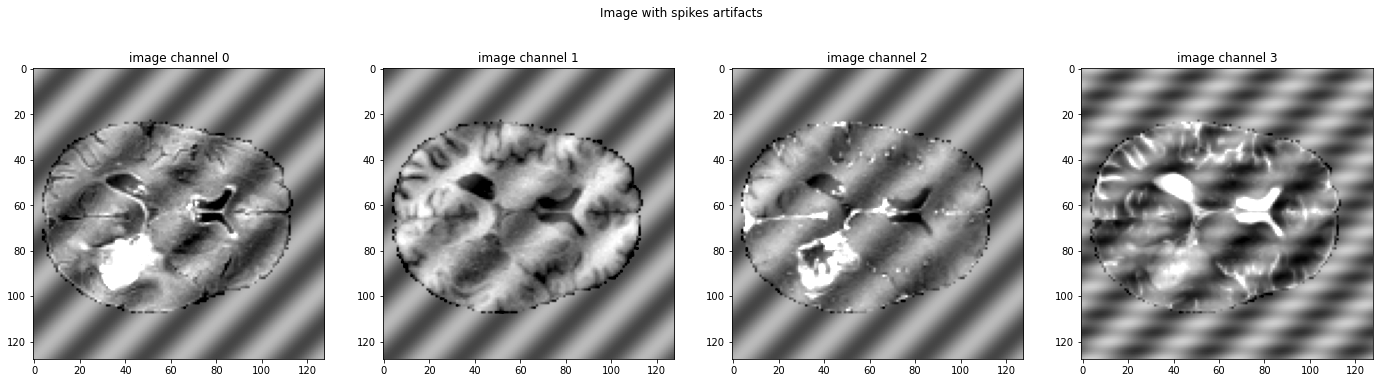

In [71]:
out = spikes(img)

plt.figure(figsize=(24,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(f'image channel {i}')
    plt.imshow(out[i, :, :, 32], cmap="gray", vmin=-2.5, vmax=2.5)
    plt.suptitle('Image with spikes artifacts')
plt.show()

#### Random version for naturalistic data augmentation

In [37]:
class RandKSpaceSpikeNoise(RandomizableTransform):
    """
    Naturalistic data augmentation via spike artifacts. The transform applies
    localized spikes in `k`-space, and it is the random version of KSpaceSpikeNoise.


    Args:
        prob: probability of applying the transform, either on all
            channels at once, or channel-wise if ``channel_wise = True``.
        intensity_range: pass a tuple
            (a, b) to sample the log-intensity from the interval (a, b)
            uniformly for all channels. Or pass sequence of intevals
            ((a0, b0), (a1, b1), ...) to sample for each respective channel.
            In the second case, the number of 2-tuples must match the number of
            channels.
            Default ranges is `(0.95x, 1.10x)` where `x` is the mean
            log-intensity for each channel.
        channel_wise: treat each channel independently. True by
            default.
        as_tensor_output: if True return torch.Tensor, else
            return np.array. default: True.
    """
    
    def __init__(
        self,
        prob: float = 0.1,
        intensity_range: Optional[Sequence[Union[Sequence[float], float]]] = None,
        channel_wise=True,
        as_tensor_output: bool = True,
    ):

        self.intensity_range = intensity_range
        self.channel_wise = channel_wise
        self.as_tensor_output = as_tensor_output
        self.sampled_k_intensity: List[float] = []
        self.sampled_locs: List[Tuple] = []

        if intensity_range is not None:
            if isinstance(intensity_range[0], Sequence) and not channel_wise:
                raise AssertionError(
                    "When channel_wise = False, intensity_range should be a 2-tuple (low, high) or None."
                )

        super().__init__(prob)
        
    def __call__(self, img: Union[np.ndarray, torch.Tensor]) -> Union[torch.Tensor, np.ndarray]:
        """
        Apply transform to `img`. Assumes data is in channel-first form.

        Args:
            img (np.array or torch.tensor): image with dimensions (C, H, W) or (C, H, W, D)
        """
        if self.intensity_range is not None:
            if isinstance(self.intensity_range[0], Sequence) and len(self.intensity_range) != img.shape[0]:
                raise AssertionError(
                    "If intensity_range is a sequence of sequences, then there must be one (low, high) tuple for each channel."
                )

        self.sampled_k_intensity = []
        self.sampled_locs = []

        # convert to ndarray to work with np.fft
        x, device = self._to_numpy(img)
        intensity_range = self._make_sequence(x)
        self._randomize(x, intensity_range)

        # build/appy transform only if there are spike locations
        if self.sampled_locs:
            transform = KSpaceSpikeNoise(self.sampled_locs, self.sampled_k_intensity, self.as_tensor_output)
            return transform(x)

        return torch.Tensor(x, device=device) if self.as_tensor_output else x

    def _randomize(self, img: np.ndarray, intensity_range: Sequence[Sequence[float]]) -> None:
        """
        Helper method to sample both the location and intensity of the spikes.
        When not working channel wise (channel_wise=False) it use the random
        variable ``self._do_transform`` to decide whether to sample a location
        and intensity.

        When working channel wise, the method randomly samples a location and
        intensity for each channel depending on ``self._do_transform``.
        """
        # randomizing per channel
        if self.channel_wise:
            for i, chan in enumerate(img):
                super().randomize(None)
                if self._do_transform:
                    self.sampled_locs.append((i,) + tuple(self.R.randint(0, k) for k in chan.shape))
                    self.sampled_k_intensity.append(self.R.uniform(intensity_range[i][0], intensity_range[i][1]))
        # working with all channels together
        else:
            super().randomize(None)
            if self._do_transform:
                spatial = tuple(self.R.randint(0, k) for k in img.shape[1:])
                self.sampled_locs = [(i,) + spatial for i in range(img.shape[0])]
                if isinstance(intensity_range[0], Sequence):
                    self.sampled_k_intensity = [self.R.uniform(*p) for p in intensity_range]
                else:
                    self.sampled_k_intensity = [self.R.uniform(*self.intensity_range)] * len(img)

    def _make_sequence(self, x: np.ndarray) -> Sequence[Sequence[float]]:
        """
        Formats the sequence of intensities ranges to Sequence[Sequence[float]].
        """
        if self.intensity_range is not None:
            if not isinstance(self.intensity_range[0], Sequence):
                intensity_range = (ensure_tuple(self.intensity_range),) * x.shape[0]
                return intensity_range
            else:
                return ensure_tuple(self.intensity_range)
        else:
            # set default range if one not provided
            return self._set_default_range(x)

    def _set_default_range(self, x: np.ndarray) -> Sequence[Sequence[float]]:
        """
        Sets default intensity ranges to be sampled.

        Args:
            x (np.ndarray): tensor to fourier transform.
        """
        n_dims = len(x.shape[1:])

        k = np.fft.fftshift(np.fft.fftn(x, axes=tuple(range(-n_dims, 0))), axes=tuple(range(-n_dims, 0)))
        log_abs = np.log(np.absolute(k) + 1e-10)
        shifted_means = np.mean(log_abs, axis=tuple(range(-n_dims, 0))) * 2.5
        intensity_sequence = tuple((i * 0.95, i * 1.1) for i in shifted_means)
        return intensity_sequence

    def _to_numpy(self, img: Union[np.ndarray, torch.Tensor]) -> Tuple[np.ndarray, torch.device]:
        if isinstance(img, torch.Tensor):
            return img.cpu().detach().numpy(), img.device
        else:
            return img, torch.device("cpu")

Example of `RandKSpaceSpikeNoise` usage:
To apply k-space spikes randomly with probability 0.7, and log-intensity sampled from the interval [13, 14] for each channel independently, one uses ``RandKSpaceSpikeNoise(prob=0.7, intensity_range=(13, 14), channel_wise=True)``

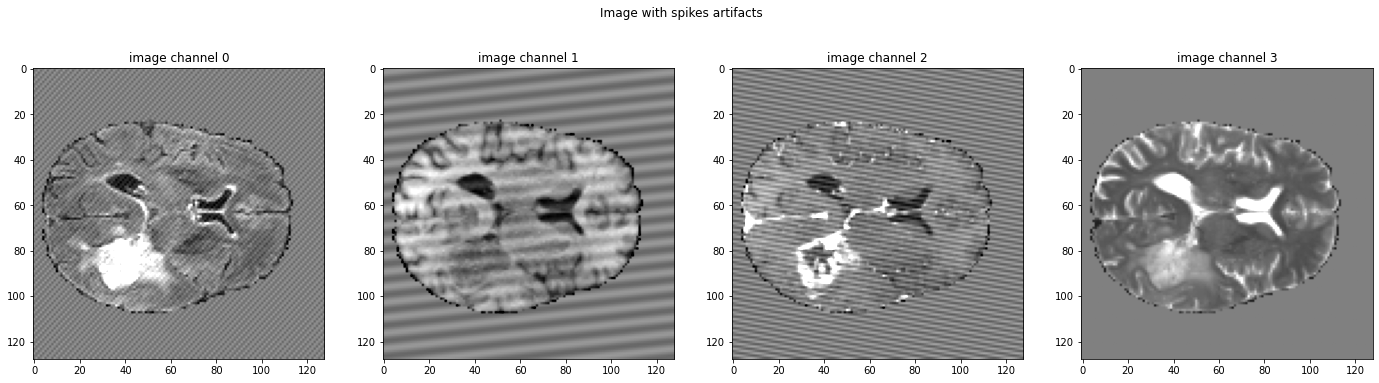

In [47]:
rand_spikes = RandKSpaceSpikeNoise(prob=0.7, intensity_range=(13, 14), channel_wise=True)

out = rand_spikes(img)

plt.figure(figsize=(24,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(f'image channel {i}')
    plt.imshow(out[i, :, :, 32], cmap="gray", vmin=-2.5, vmax=2.5)
    plt.suptitle('Image with spikes artifacts')
plt.show()

# Wraparound (aliasing) artifact

Aliasing of the signal leads to the data wrapping around the image.

[An Introduction to the Fourier Transform: Relationship to MRI.](https://www.ajronline.org/doi/pdf/10.2214/AJR.07.2874)

![wraparound_example](figures/wraparound_example.png)

In [80]:
class WrapArtifact(Transform, FourierTransform):
    """
    Applies wrapping artifacts while keeping the size of the image
    fixed.

    Args:
        alpha (float): regulates amplitude of wraparound artifact 

    When called, it assumes the data has shape: (C,H,W) or (C,H,W,D).
    """

    def __init__(self, alpha: float = 0.5):

        self.alpha = alpha

    def __call__(self, img: torch.tensor):

        n_dims = len(img.shape[1:])
        # FT
        k = self.shift_fourier(img, n_dims)
        # reduce information
        k[:,1:k.size(1):2,:,:] = k[:,1:k.size(1):2,:,:] * self.alpha
        k[:,:,1:k.size(2):2,:] = k[:,:,1:k.size(2):2,:] * self.alpha
        k[:,:,:,1:k.size(3):2] = k[:,:,:,1:k.size(3):2] * self.alpha
        # map back
        img = self.inv_shift_fourier(k, n_dims)
        
        return img

Example of `WrapArtifact` applied with increasing intensity: 

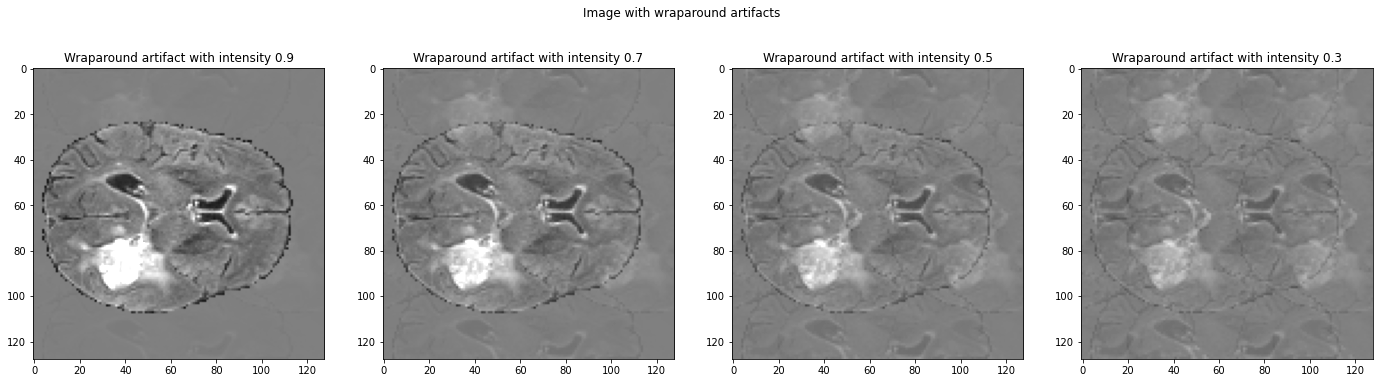

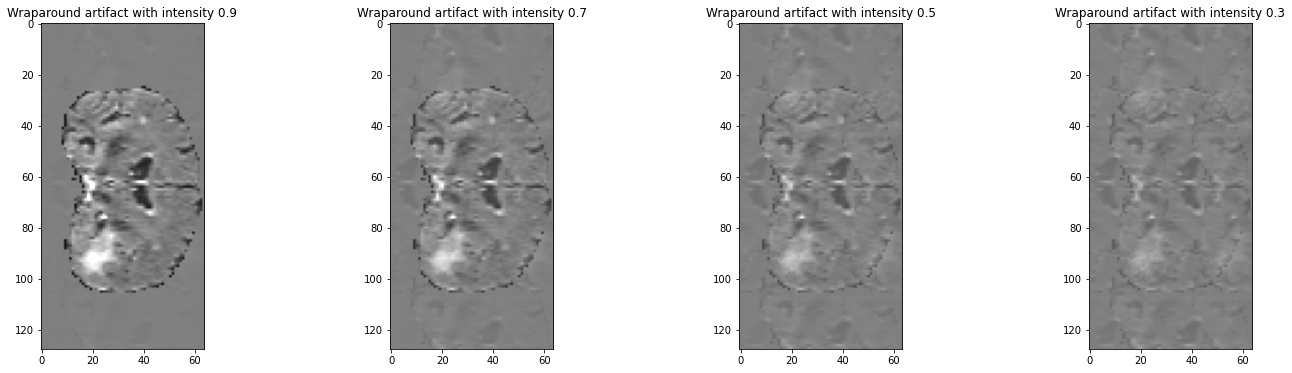

In [79]:
plt.figure(figsize=(24,6))
for i, val in enumerate([0.90, 0.70, 0.50, 0.30]):
    wrap = WrapArtifact(val)
    out = wrap(img)
    plt.subplot(1,4,i+1)
    plt.title(f'Wraparound artifact with intensity {val}')
    plt.imshow(out[0, :, :, 32], cmap="gray", vmin=-2.5, vmax=2.5)
    plt.suptitle('Image with wraparound artifacts')
plt.show()

plt.figure(figsize=(24,6))
for i, val in enumerate([0.90, 0.70, 0.50, 0.30]):
    wrap = WrapArtifact(val)
    out = wrap(img)
    plt.subplot(1,4,i+1)
    plt.title(f'Wraparound artifact with intensity {val}')
    plt.imshow(out[0, :, 64, :], cmap="gray", vmin=-2.5, vmax=2.5)
plt.show()